### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# Install required libs
!pip install --force-reinstall albumentations==0.3.0

### please update Albumentations to version>=0.3.0 for `Lambda` transform support


# Loading dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/A3_Dataset.zip', 'r') as p:
    p.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    p.extractall()

In [8]:
y_train_dir="/content/A3_Dataset/dataset1/annotations_prepped_train"
x_train_dir="/content/A3_Dataset/dataset1/images_prepped_train"
y_test_dir= "/content/A3_Dataset/dataset1/annotations_prepped_test"
x_test_dir="/content/A3_Dataset/dataset1/images_prepped_test"

In [9]:
!pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from scipy import io as sio

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        print(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        image =cv2.resize(image, (320,320), interpolation = cv2.INTER_AREA)
        mask=cv2.resize(mask,(320,320), interpolation = cv2.INTER_AREA)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.all_utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [ ]:
import torch
# Lets look at data we have
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[18] # get some sample
noclass=[0,0,0,0,0,0,0,0,0,0,0,0]
for i in dataset:
  image, mask = i
  for j in range(0,12):
    count = np.count_nonzero(mask[:,:,j] == 1)
    noclass[j]=noclass[j]+count;
t=min(noclass)
newList = [sum(noclass) / (12*x) for x in noclass]
print(newList)
weight = []
for k in range(12):
  t=np.ndarray(shape=(320,320), dtype=float)
  for i in range(320):
    for j in range(320):
      t[i][j]=newList[0]
  weight.append(t)
weight = torch.Tensor(weight) 
print(weight.shape)

image, mask = dataset[250] # get some sample

#print(mask)
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    #background_mask=mask[..., 2].squeeze(),
)

### Augmentations

In [13]:
import albumentations as A

In [14]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

['0006R0_f02580.png', '0016E5_00750.png', '0016E5_05040.png', '0006R0_f01290.png', '0016E5_05820.png', '0001TP_007320.png', '0016E5_07200.png', '0001TP_008130.png', '0001TP_007980.png', '0016E5_00870.png', '0001TP_007530.png', '0001TP_008100.png', '0001TP_007230.png', '0006R0_f03300.png', '0016E5_05310.png', '0001TP_007500.png', '0016E5_06300.png', '0016E5_01620.png', '0016E5_02130.png', '0001TP_007890.png', '0016E5_05340.png', '0006R0_f02520.png', '0016E5_05280.png', '0001TP_007800.png', '0001TP_008430.png', '0016E5_05160.png', '0001TP_006990.png', '0006R0_f01590.png', '0016E5_01410.png', '0006R0_f03900.png', '0016E5_00840.png', '0016E5_04410.png', '0016E5_01980.png', '0006R0_f02370.png', '0006R0_f01050.png', '0001TP_008160.png', '0016E5_07230.png', '0006R0_f01500.png', '0016E5_05370.png', '0016E5_08550.png', '0006R0_f03090.png', '0001TP_008460.png', '0016E5_05880.png', '0006R0_f02160.png', '0001TP_007440.png', '0016E5_06780.png', '0006R0_f01350.png', '0006R0_f02610.png', '0016E5_0468

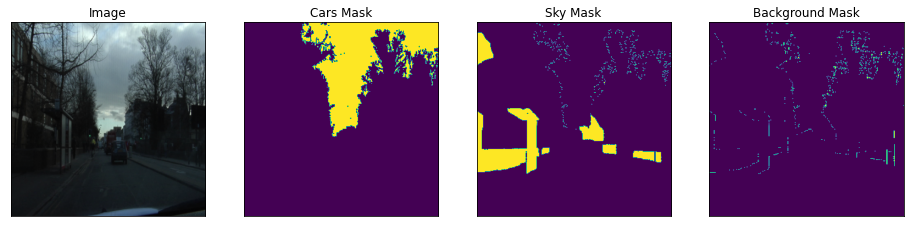

In [15]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

In [20]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 6.2 MB/s 


# Segmentation model training

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [22]:
BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes=12
activation = 'sigmoid' if n_classes == 1 else 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [24]:
import keras.backend as K
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [ ]:
import tensorflow as tf
# define optomizer
optim = tf.keras.optimizers.Adam(LR)
print(newList)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sensitivity,specificity,sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [26]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),

    )
# Dataset for validation images
valid_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

['0006R0_f02580.png', '0016E5_00750.png', '0016E5_05040.png', '0006R0_f01290.png', '0016E5_05820.png', '0001TP_007320.png', '0016E5_07200.png', '0001TP_008130.png', '0001TP_007980.png', '0016E5_00870.png', '0001TP_007530.png', '0001TP_008100.png', '0001TP_007230.png', '0006R0_f03300.png', '0016E5_05310.png', '0001TP_007500.png', '0016E5_06300.png', '0016E5_01620.png', '0016E5_02130.png', '0001TP_007890.png', '0016E5_05340.png', '0006R0_f02520.png', '0016E5_05280.png', '0001TP_007800.png', '0001TP_008430.png', '0016E5_05160.png', '0001TP_006990.png', '0006R0_f01590.png', '0016E5_01410.png', '0006R0_f03900.png', '0016E5_00840.png', '0016E5_04410.png', '0016E5_01980.png', '0006R0_f02370.png', '0006R0_f01050.png', '0001TP_008160.png', '0016E5_07230.png', '0006R0_f01500.png', '0016E5_05370.png', '0016E5_08550.png', '0006R0_f03090.png', '0001TP_008460.png', '0016E5_05880.png', '0006R0_f02160.png', '0001TP_007440.png', '0016E5_06780.png', '0006R0_f01350.png', '0006R0_f02610.png', '0016E5_0468

In [27]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
45/45 [==============================] - 46s 568ms/step - loss: 0.9221 - sensitivity: 0.0488 - specificity: 0.9977 - iou_score: 0.0297 - f1-score: 0.0474 - accuracy: 0.3441 - val_loss: 0.8622 - val_sensitivity: 0.1777 - val_specificity: 0.9953 - val_iou_score: 0.0838 - val_f1-score: 0.1065 - val_accuracy: 0.6998 - lr: 1.0000e-04
Epoch 2/100
45/45 [==============================] - 27s 592ms/step - loss: 0.8155 - sensitivity: 0.4014 - specificity: 0.9943 - iou_score: 0.1836 - f1-score: 0.2449 - accuracy: 0.5589 - val_loss: 0.7856 - val_sensitivity: 0.4986 - val_specificity: 0.9950 - val_iou_score: 0.1827 - val_f1-score: 0.2323 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 3/100
45/45 [==============================] - 25s 544ms/step - loss: 0.7496 - sensitivity: 0.6244 - specificity: 0.9933 - iou_score: 0.2632 - f1-score: 0.3210 - accuracy: 0.6119 - val_loss: 0.7488 - val_sensitivity: 0.6436 - val_specificity: 0.9972 - val_iou_score: 0.2882 - val_f1-score: 0.3416 - val_accur

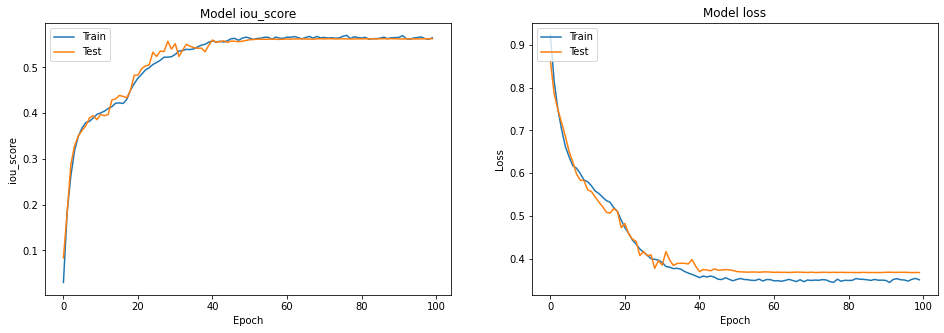

In [41]:
# Plot training & validation iou_score values
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [36]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

['0016E5_08039.png', '0016E5_08131.png', '0016E5_08041.png', '0016E5_08073.png', '0016E5_07999.png', '0016E5_07995.png', '0016E5_08129.png', '0016E5_08009.png', '0016E5_08019.png', '0016E5_08065.png', '0016E5_08151.png', '0016E5_07959.png', '0016E5_08055.png', '0016E5_08047.png', '0016E5_08011.png', '0016E5_07965.png', '0016E5_07993.png', '0016E5_08081.png', '0016E5_08037.png', '0016E5_08123.png', '0016E5_08057.png', '0016E5_07973.png', '0016E5_08101.png', '0016E5_08111.png', '0016E5_08133.png', '0016E5_08063.png', '0016E5_08051.png', '0016E5_08069.png', '0016E5_08079.png', '0016E5_08007.png', '0016E5_07983.png', '0016E5_08119.png', '0016E5_08095.png', '0016E5_08053.png', '0016E5_08013.png', '0016E5_08017.png', '0016E5_08099.png', '0016E5_07963.png', '0016E5_08137.png', '0016E5_08071.png', '0016E5_07971.png', '0016E5_07989.png', '0016E5_08147.png', '0016E5_08059.png', '0016E5_08091.png', '0016E5_07991.png', '0016E5_08061.png', '0016E5_08141.png', '0016E5_08083.png', '0016E5_08089.png',

In [37]:
# load best weights
model.load_weights('best_model.h5') 

In [40]:
scores = model.evaluate_generator(test_dataloader)

print(scores)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.34885719418525696, 0.9046258330345154, 0.9918887615203857, 0.5829687714576721, 0.670841634273529, 0.906364381313324]


# Visualization of results on test dataset

101
0


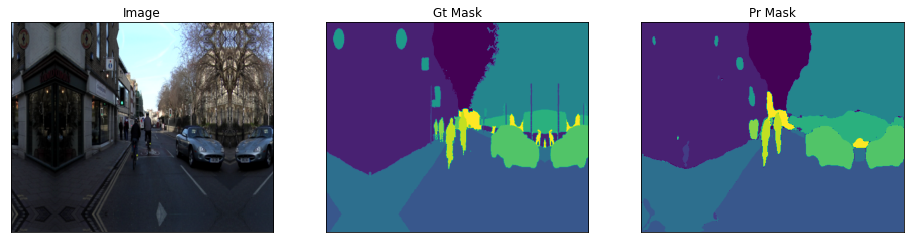

1


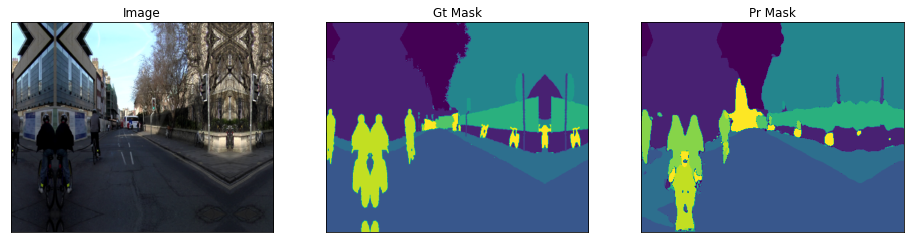

5


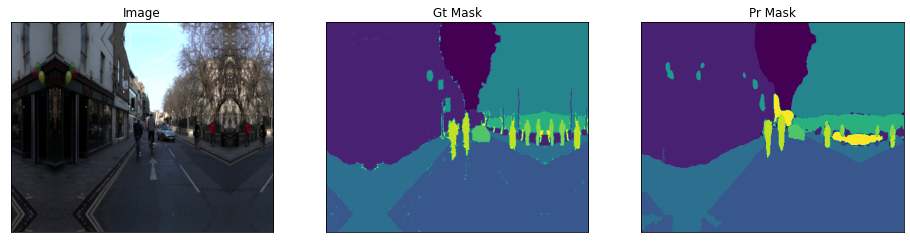

60


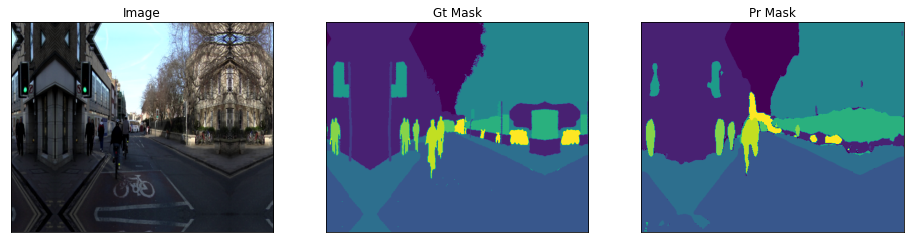

12


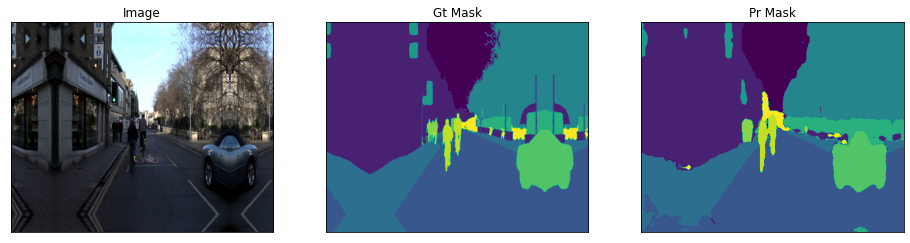

In [39]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)
ids=[0,1,5,60,12]
print(len(test_dataset))
for i in ids:
    print(i)
    image, gt_mask = valid_dataset[i]
    gt_mask=np.argmax(gt_mask,axis=2) 
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    pr_mask=np.argmax(pr_mask,axis=3) 
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(0),
    )

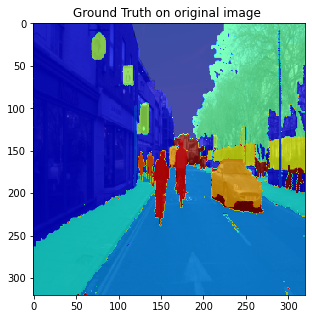

In [50]:
image, gt_mask = test_dataset[100]
gt_mask=np.argmax(gt_mask,axis=2) 
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image).round()
pr_mask=np.argmax(pr_mask,axis=3) 
   
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.imshow(image.squeeze(), interpolation='none')
plt.imshow(gt_mask.squeeze(), 'jet', interpolation='none', alpha=0.7)
plt.title("Ground Truth on original image ")

#plt.subplot(1,2,2)
#plt.imshow(image.squeeze(), 'gray', interpolation='none')
#plt.imshow(pr_mask.squeeze(0), 'jet', interpolation='none', alpha=0.7)
#plt.title("Predicted Truth on original image")

plt.show()
